In [14]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="2"

Imports

In [15]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import *
from utils import *
from interp_utils import *
from probing import *
from sparse_coding import *

Dataset

Loading contents from file...


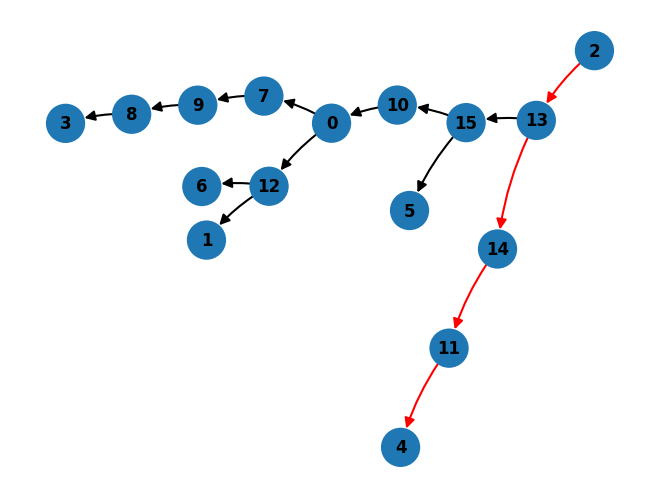

In [16]:
n_examples = 300_000
n_states = 16
dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)

Model

In [17]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


# Load in the model if weights are in the directory, else train new model
if os.path.exists("model.pt"):
    model.load_state_dict(torch.load("model.pt"))

### Dataset

SAE

In [18]:
sae = SparseCoder(num_codes=4*model.cfg.d_model, verbose=True)

In [19]:
# load
checkpoint = torch.load('sae_block_4_hook_resid_post.pt')
sae.construct_model(128)
sae.model.load_state_dict(checkpoint)
sae.model.to('cuda')

this is the Anthropic SAE


SparseAutoencoder()

Visualizations

In [20]:
def get_learned_dict(sae):
    norms = torch.norm(sae.model.W_e, 2, dim=-1)
    return sae.model.W_e / torch.clamp(norms, 1e-8)[:, None]

dict = get_learned_dict(sae)

In [21]:
# Now we can use the model to get the activations
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from einops import rearrange
from itertools import islice
max_seq_length = dataset.max_seq_length - 1
device = 'cuda'
sae.model.to(device)
def get_dictionary_activations(model, dataset, cache_name, autoencoder, batch_size=32,datapoints=32):
    num_features, d_model = autoencoder.model.W_e.shape
    
    dictionary_activations = torch.zeros((datapoints*max_seq_length, num_features))
    token_list = torch.zeros((datapoints*max_seq_length), dtype=torch.int64)
    with torch.no_grad():
        dl = DataLoader(dataset, batch_size=batch_size)
        for i, batch in enumerate(tqdm(islice(dl,int(datapoints/batch_size)))):
            batch = batch[0][:, :-1].to(device)
            token_list[i*batch_size*max_seq_length:(i+1)*batch_size*max_seq_length] = rearrange(batch, "b s -> (b s)")
            _, cache = model.run_with_cache(batch.to(device))
            batched_neuron_activations = rearrange(cache[cache_name], "b s n -> (b s) n" )
            batched_dictionary_activations, _ = autoencoder.model(batched_neuron_activations.cuda())
            dictionary_activations[i*batch_size*max_seq_length:(i+1)*batch_size*max_seq_length,:] = batched_dictionary_activations.cpu()
    return dictionary_activations, token_list
dataset_small=dataset[0:32]
print("Getting dictionary activations")
#datapoints = len(dataset)
datapoints=32*1000
dictionary_activations, tokens_for_each_datapoint = get_dictionary_activations(model, dataset, 'blocks.4.hook_resid_post', sae, batch_size=32,datapoints=datapoints)

Getting dictionary activations


1000it [00:19, 51.71it/s]


In [22]:
# look at feature density / look at features which activate a lot / highly affect logits

In [23]:

from collections import defaultdict

def get_feature_indices(feature_index, dictionary_activations, k=10, setting="max"):
    best_feature_activations = dictionary_activations[:, feature_index]
    # Sort the features by activation, get the indices
    if setting=="max":
        found_indices = torch.argsort(best_feature_activations, descending=True)[:k]
    elif setting=="uniform":
        # min_value = torch.min(best_feature_activations)
        min_value = torch.min(best_feature_activations)
        max_value = torch.max(best_feature_activations)

        # Define the number of bins
        num_bins = k

        # Calculate the bin boundaries as linear interpolation between min and max
        bin_boundaries = torch.linspace(min_value, max_value, num_bins + 1)

        # Assign each activation to its respective bin
        bins = torch.bucketize(best_feature_activations, bin_boundaries)

        # Initialize a list to store the sampled indices
        sampled_indices = []

        # Sample from each bin
        for bin_idx in torch.unique(bins):
            if(bin_idx==0): # Skip the first one. This is below the median
                continue
            # Get the indices corresponding to the current bin
            bin_indices = torch.nonzero(bins == bin_idx, as_tuple=False).squeeze(dim=1)
            
            # Randomly sample from the current bin
            sampled_indices.extend(np.random.choice(bin_indices, size=1, replace=False))

        # Convert the sampled indices to a PyTorch tensor & reverse order
        found_indices = torch.tensor(sampled_indices).long().flip(dims=[0])
    else: # random
        # get nonzero indices
        nonzero_indices = torch.nonzero(best_feature_activations)[:, 0]
        # shuffle
        shuffled_indices = nonzero_indices[torch.randperm(nonzero_indices.shape[0])]
        found_indices = shuffled_indices[:k]
    return found_indices

def get_feature_datapoints(found_indices, best_feature_activations, max_seq_length, dataset):
    num_datapoints = datapoints
    print(num_datapoints)
    datapoint_indices =[np.unravel_index(i, (num_datapoints, max_seq_length)) for i in found_indices]
    all_activations = best_feature_activations.reshape(num_datapoints, max_seq_length).tolist()
    full_activations = []
    partial_activations = []
    text_list = []
    full_text = []
    token_list = []
    full_token_list = []
    for i, (md, s_ind) in enumerate(datapoint_indices):
        if s_ind == 47:
            md = int(md)
            s_ind = int(s_ind)
            full_tok = torch.tensor(dataset[md][0])
            full_text.append(dataset.untokenize(full_tok))
            tok = dataset[md][0][:s_ind+1]
            full_activations.append(all_activations[md])
            partial_activations.append(all_activations[md][:s_ind+1])
            text = dataset.untokenize(tok)
            text_list.append(text)
            token_list.append(tok)
            full_token_list.append(full_tok)
    return text_list, full_text, token_list, full_token_list, partial_activations, full_activations


import os



In [24]:
# make features/ dir if not exist
save_path = "features/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
num_feature_datapoints = 10000

# features = [1,2,3,4,5,6,7,8,9,10]
feature = 3
uniform_indices = get_feature_indices(feature, dictionary_activations, k=num_feature_datapoints, setting="uniform")
text_list, full_text, token_list, full_token_list, partial_activations, full_activations = get_feature_datapoints(uniform_indices, dictionary_activations[:, feature], max_seq_length, dataset)
text_list

32000


[]

In [36]:
n = 10
for subset, full in zip(text_list[:n], full_text[:n]):
    print(subset)
    parse_example(full)
    plt.show()

In [26]:
#lowest activated examples
n = 10
for subset, full in zip(text_list[-n:], full_text[-n:]):
    print(subset)
    parse_example(full)
    plt.show()

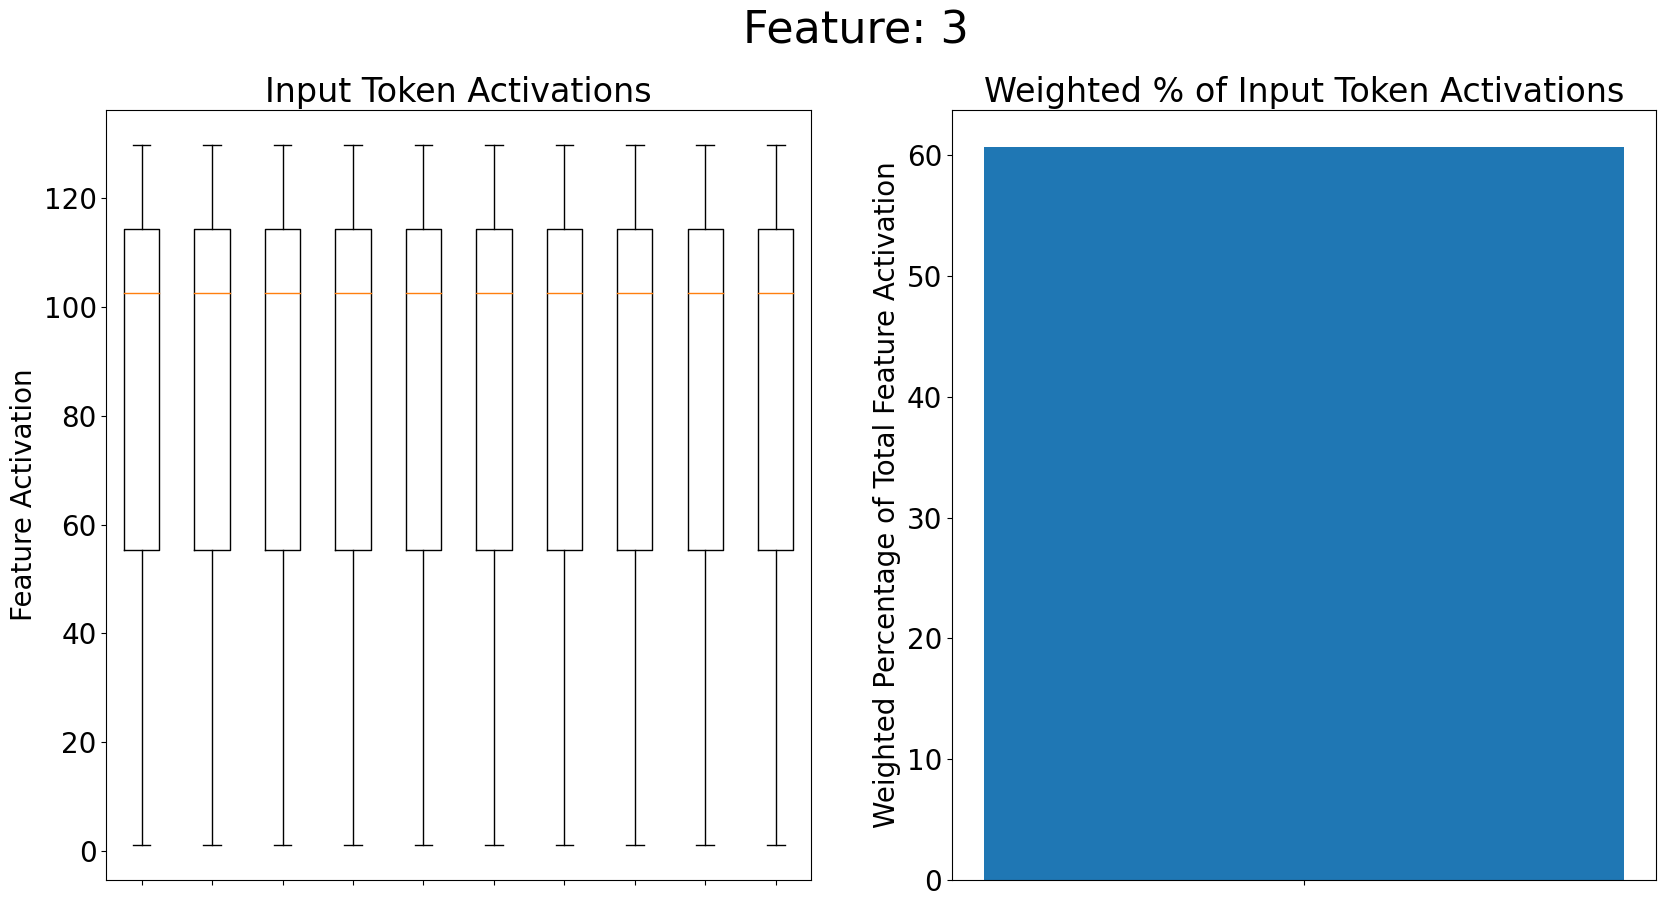

In [27]:
def get_token_statistics(feature, feature_activation, dataset, max_seq_length, tokens_for_each_datapoint, save_location="", num_unique_tokens=10, setting="input", negative_threshold=-0.01):
    if(setting=="input"):
        nonzero_indices = feature_activation.nonzero()[:, 0]  # Get the nonzero indices
    else:
        nonzero_indices = (feature_activation < negative_threshold).nonzero()[:, 0]
    nonzero_values = feature_activation[nonzero_indices].abs()  # Get the nonzero values

    # Unravel the indices to get the token IDs
    datapoint_indices = [np.unravel_index(i, (len(dataset), max_seq_length)) for i in nonzero_indices]
    all_tokens = [dataset[int(md)][0][int(s_ind)] for md, s_ind in datapoint_indices]

    # Find the max value for each unique token
    token_value_dict = defaultdict(int)
    for token, value in zip(all_tokens, nonzero_values):
        token_value_dict[token] = max(token_value_dict[token], value)
    # if(setting=="input"):
    sorted_tokens = sorted(token_value_dict.keys(), key=lambda x: -token_value_dict[x])
    # else:
    #     sorted_tokens = sorted(token_value_dict.keys(), key=lambda x: token_value_dict[x])
    # Take the top 10 (or fewer if there aren't 10)
    max_tokens = sorted_tokens[:min(num_unique_tokens, len(sorted_tokens))]
    total_sums = nonzero_values.abs().sum()
    max_token_sums = []
    token_activations = []
    assert len(max_tokens) > 0, "No tokens found for this feature"
    for max_token in max_tokens:
        # Find ind of max token
        max_token_indices = tokens_for_each_datapoint[nonzero_indices] == max_token
        # Grab the values for those indices
        max_token_values = nonzero_values[max_token_indices]
        max_token_sum = max_token_values.abs().sum()
        max_token_sums.append(max_token_sum)
        token_activations.append(max_token_values)

    if(setting=="input"):
        title_text = "Input Token Activations"
        save_name = "input"
        y_label = "Feature Activation"
    else:
        title_text = "Output Logit-Difference"
        save_name = "logit_diff"
        y_label = "Logit Difference"

    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    # Add a supreme title for the entire figure
    if(setting=="input"):
        fig.suptitle(f"Feature: {feature}", fontsize=32)

    # Boxplot on the left
    ax = axs[0]
    ax.set_title(f'{title_text}')
    max_text = [dataset.untokenize([t]).replace("\n", "\\n").replace(" ", "_") for t in max_tokens]
    ax.set_ylabel(y_label)
    plt.sca(ax)
    plt.xticks(rotation=35)
    ax.title.set_size(24)
    ax.yaxis.label.set_size(20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.boxplot(token_activations[::-1], labels=max_text[::-1])

    # Bar graph on the right
    ax = axs[1]
    ax.set_title(f'Weighted % of {title_text}')
    plt.sca(ax)
    plt.xticks(rotation=35)
    ax.title.set_size(24)
    ax.yaxis.label.set_size(20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel(f'Weighted Percentage of Total {y_label}')
    ax.bar(max_text[::-1], [t/total_sums*100 for t in max_token_sums[::-1]])

    # Save the figure
    plt.savefig(f'{save_location}feature_{feature}_{save_name}_combined.png', bbox_inches='tight')

    return

get_token_statistics(feature, dictionary_activations[:, feature], dataset, max_seq_length, tokens_for_each_datapoint, save_location = save_path, num_unique_tokens=10)

In [28]:
feature, feature_activation, dataset, max_seq_length, tokens_for_each_datapoint, save_location, num_unique_tokens, setting, negative_threshold = feature, dictionary_activations[:, feature], dataset, max_seq_length, tokens_for_each_datapoint, save_path, 10, "input", -0.01

if(setting=="input"):
    nonzero_indices = feature_activation.nonzero()[:, 0]  # Get the nonzero indices
else:
    nonzero_indices = (feature_activation < negative_threshold).nonzero()[:, 0]
nonzero_values = feature_activation[nonzero_indices].abs()  # Get the nonzero values

# Unravel the indices to get the token IDs
datapoint_indices = [np.unravel_index(i, (len(dataset), max_seq_length)) for i in nonzero_indices]

In [29]:
len([md for md in nonzero_values])

1869955

In [30]:
all_tokens = [dataset[int(md)][0][int(s_ind)] for md, s_ind in datapoint_indices]

In [31]:
all_graphs = [dataset[int(md)][0] for md, s_ind in datapoint_indices]

In [32]:
len(all_graphs)

1869955

In [33]:
# Find the max value for each unique token
token_value_dict = defaultdict(int)
for token, value in zip(all_tokens, nonzero_values):
    token_value_dict[token] = max(token_value_dict[token], value)
# if(setting=="input"):
sorted_tokens = sorted(token_value_dict.keys(), key=lambda x: -token_value_dict[x])
# else:
#     sorted_tokens = sorted(token_value_dict.keys(), key=lambda x: token_value_dict[x])
# Take the top 10 (or fewer if there aren't 10)
max_tokens = sorted_tokens[:min(num_unique_tokens, len(sorted_tokens))]
total_sums = nonzero_values.abs().sum()
max_token_sums = []
token_activations = []
assert len(max_tokens) > 0, "No tokens found for this feature"
for max_token in max_tokens:
    # Find ind of max token
    max_token_indices = tokens_for_each_datapoint[nonzero_indices] == max_token
    # Grab the values for those indices
    max_token_values = nonzero_values[max_token_indices]
    max_token_sum = max_token_values.abs().sum()
    max_token_sums.append(max_token_sum)
    token_activations.append(max_token_values)

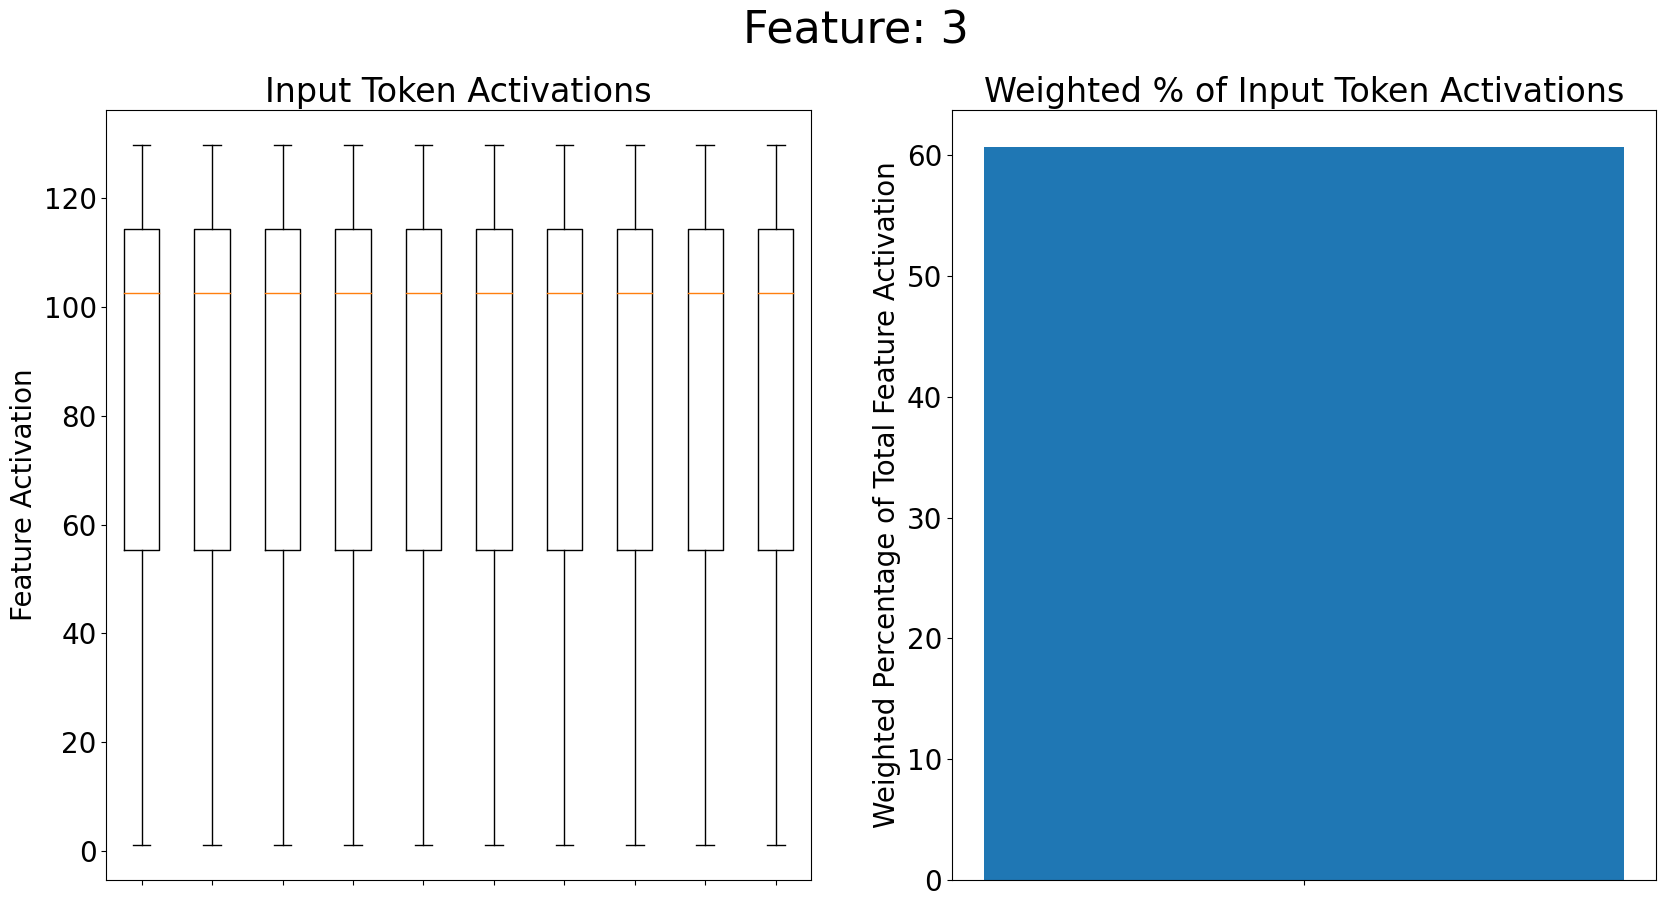

In [34]:
if(setting=="input"):
    title_text = "Input Token Activations"
    save_name = "input"
    y_label = "Feature Activation"
else:
    title_text = "Output Logit-Difference"
    save_name = "logit_diff"
    y_label = "Logit Difference"

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Add a supreme title for the entire figure
if(setting=="input"):
    fig.suptitle(f"Feature: {feature}", fontsize=32)

# Boxplot on the left
ax = axs[0]
ax.set_title(f'{title_text}')
max_text = [dataset.untokenize([t]).replace("\n", "\\n").replace(" ", "_") for t in max_tokens]
ax.set_ylabel(y_label)
plt.sca(ax)
plt.xticks(rotation=35)
ax.title.set_size(24)
ax.yaxis.label.set_size(20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.boxplot(token_activations[::-1], labels=max_text[::-1])

# Bar graph on the right
ax = axs[1]
ax.set_title(f'Weighted % of {title_text}')
plt.sca(ax)
plt.xticks(rotation=35)
ax.title.set_size(24)
ax.yaxis.label.set_size(20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylabel(f'Weighted Percentage of Total {y_label}')
ax.bar(max_text[::-1], [t/total_sums*100 for t in max_token_sums[::-1]])

# Save the figure
plt.savefig(f'{save_location}feature_{feature}_{save_name}_combined.png', bbox_inches='tight')